Verschiedene Ansätze um die Daten zu analysieren.

In [16]:
import numpy as np
import pandas as pd
import scipy
import sys
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

sys.path.append(os.path.dirname(os.getcwd()))
from src.load_covid19 import load_clean_covid19

df = load_clean_covid19()

# # male cannot be pregnant
# df.loc[df.SEX == 'male', 'PREGNANT'] = False
# # zuhause kann nicht beatmet werde & intubiert werden
# df.loc[df.PATIENT_TYPE=='athome','ICU']=False
# df.loc[df.PATIENT_TYPE=='athome','INTUBED']=False

# print(df.isna().sum())
# bool_columns = ['PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 
#                 'HIPERTENSION', 'CARDIOVASCULAR', 'RENAL_CHRONIC', 'OTHER_DISEASE', 'OBESITY', 'TOBACCO', 
#                 'INTUBED', 'ICU', 'DIED']
# for i in bool_columns:
#     df[i] = df[i].fillna(False)

# df.isna().sum()



Dataset already exists at s:\SynologyDrive\SynologyDrive\Uni\Master 2\3. Semester\Projektpraktikum Web Science\covid-19-risiko-erkennung\src\..\data\raw\covid19-dataset. Skipping download.
Saving clean dataset to: s:\SynologyDrive\SynologyDrive\Uni\Master 2\3. Semester\Projektpraktikum Web Science\covid-19-risiko-erkennung\data\interim\covid-data-clean.csv
Saved
Loading clean dataset from: s:\SynologyDrive\SynologyDrive\Uni\Master 2\3. Semester\Projektpraktikum Web Science\covid-19-risiko-erkennung\data\interim\covid-data-clean.csv


C:\Users\Rafa\AppData\Local\Temp\ipykernel_30944\884029518.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.SEX).SEX.count().plot(kind="pie", autopct="%1.1f%%")


<Axes: ylabel='SEX'>

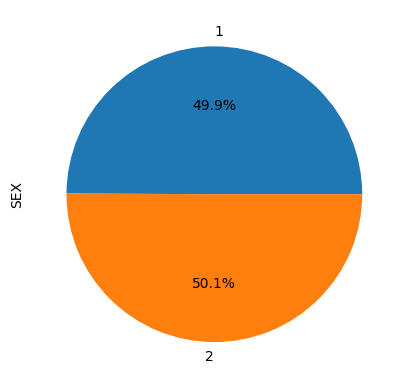

In [17]:
df.PATIENT_TYPE.unique()
df.groupby(df.SEX).SEX.count().plot(kind="pie", autopct="%1.1f%%")

In [18]:

df['SEX'] = df['SEX'].replace('female', 0).replace('male', 1)
df['PATIENT_TYPE'] = df['PATIENT_TYPE'].replace('returned home', 0).replace('hospitalization', 1)


df['AT_RISK'] = df['DIED']+df['INTUBED']+df['ICU']


df.AT_RISK = df.AT_RISK.apply(lambda x: 1 if x > 0 else 0) 
df = df.drop(columns = ['DIED', 'INTUBED', 'ICU'])


# train(90%), test(5%)
train, test = train_test_split(df, test_size=0.1, shuffle=True)

# df.to_csv("../data/raw/covid19-dataset/Covid Data2.csv")

train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()


test_y = test.AT_RISK.to_numpy()
test_x = test.drop(columns = ['AT_RISK']).to_numpy()


def get_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    return acc, f1, prec, rec

KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix


# undersampling the train set
undersampling = 10000
train_xus = train_x[:undersampling]
train_yus = train_y[:undersampling]
test_xus = test_x[:undersampling]
test_yus = test_y[:undersampling]



ks = [5,7,9]
# ks = [1,3,5,7,9]
accs = []
f1s = []
precs = []
recs = []

for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    knn_model.fit(train_xus, train_yus)
    # Scale the features using StandardScaler
    # scaler = StandardScaler()
    # test_x_std = scaler.fit_transform(validation_x)
    # X_test = scaler.transform(X_test)

    y_pred = knn_model.predict(test_xus)
    acc, f1, prec, rec = get_scores(test_yus, y_pred)
    accs.append(acc)
    f1s.append(f1)
    precs.append(prec)
    recs.append(rec)
    print(f"k: {k} - {acc} {f1} {prec} {rec}")





k: 5 - 0.9279 0.4975609756097561 0.601010101010101 0.4244946492271106
k: 7 - 0.9281 0.49115357395612175 0.6066433566433567 0.4126040428061831
k: 9 - 0.9277 0.48540925266903917 0.6046099290780141 0.4054696789536266


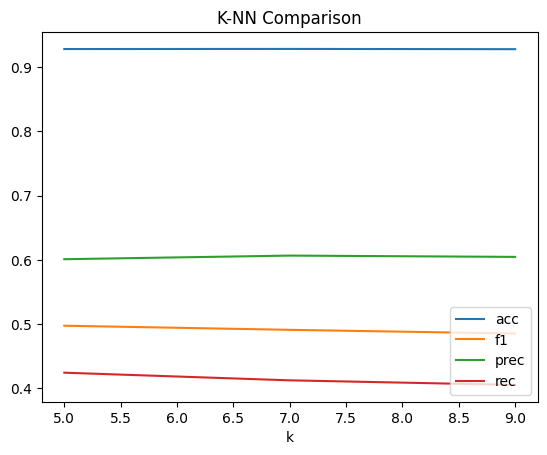

In [20]:
import matplotlib.pyplot as plt

plt.title('K-NN Comparison')
plt.errorbar(ks, accs, label="acc")
plt.errorbar(ks, f1s, label="f1")
plt.errorbar(ks, precs, label="prec")
plt.errorbar(ks, recs, label="rec")
plt.legend(loc ='lower right')
plt.xlabel('k')
plt.show()

Decision Tree

In [26]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


# undersampling the train set
undersampling = 10000
train_xus = train_x[:undersampling]
train_yus = train_y[:undersampling]
test_xus = test_x[:undersampling]
test_yus = test_y[:undersampling]


heuristics = ["entropy", "gini"]
splitters = ["best", "random"]
max_depth = [3, 5, 7, 11, 13, 17, 19]
dt_fmeasures = {}
dt_best_result = 0
dt_best = None

for d in max_depth:
    dt_fmeasures[d] = np.zeros(len(heuristics)*len(splitters))
    i=0
    for heuristic, splitter in [(heuristic, splitter) for heuristic in heuristics for splitter in splitters]:
        # create a Decision Tree classifier instance and compute the prediction
        dt_classifier = DecisionTreeClassifier(criterion=heuristic, splitter=splitter, max_depth=d, class_weight='balanced')
        dt_classifier.fit(train_xus, train_yus)
        y_pred = dt_classifier.predict(test_xus)

        # calculate F-measures and save best model
        acc, f1, prec, rec = get_scores(test_yus, y_pred)
        dt_fmeasures[d][i] = acc
        print(f"{d}:{heuristic} {splitter}: f1: {f1} acc: {acc}")
        i=i+1

        if f1 > dt_best_result:
            dt_best_result = f1
            dt_best = dt_classifier




3:entropy best: f1: 0.5705082319255548 acc: 0.88
3:entropy random: f1: 0.5453315290933695 acc: 0.8656
3:gini best: f1: 0.5705082319255548 acc: 0.88
3:gini random: f1: 0.5453315290933695 acc: 0.8656
5:entropy best: f1: 0.5840840840840841 acc: 0.8892
5:entropy random: f1: 0.5768807339449541 acc: 0.8847
5:gini best: f1: 0.582061778935616 acc: 0.8877
5:gini random: f1: 0.5619081024202034 acc: 0.8751
7:entropy best: f1: 0.5725398677557371 acc: 0.8901
7:entropy random: f1: 0.5698240359415949 acc: 0.8851
7:gini best: f1: 0.57992277992278 acc: 0.8912
7:gini random: f1: 0.5846509834168916 acc: 0.8923
11:entropy best: f1: 0.5782608695652174 acc: 0.903
11:entropy random: f1: 0.5806182121971596 acc: 0.8996
11:gini best: f1: 0.5699208443271768 acc: 0.9022
11:gini random: f1: 0.5798915310805173 acc: 0.8993
13:entropy best: f1: 0.5504672897196262 acc: 0.9038
13:entropy random: f1: 0.5705215419501134 acc: 0.9053
13:gini best: f1: 0.5503041647168928 acc: 0.9039
13:gini random: f1: 0.5409610983981693 ac

0.5869649055148477


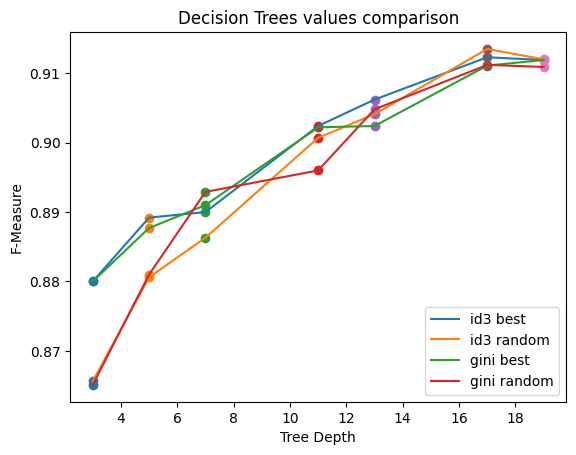

In [22]:
print(dt_best_result)



l1, l2, l3, l4 = [], [], [], []
for k in dt_fmeasures.keys():
    fmeasures = dt_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(dt_fmeasures[k][0])
    l2.append(dt_fmeasures[k][1])
    l3.append(dt_fmeasures[k][2])
    l4.append(dt_fmeasures[k][3])

plt.errorbar(max_depth, l1, label ='id3 best')
plt.errorbar(max_depth, l2, label ='id3 random')
plt.errorbar(max_depth, l3, label ='gini best')
plt.errorbar(max_depth, l4, label ='gini random')
plt.legend(loc ='lower right')
plt.title('Decision Trees values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.show()

# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dt_classifier,
#                 #    feature_names=iris.feature_names,
#                 #    class_names=iris.target_names,
#                    filled=True)


SVM

linear:0.5652808169219548 - 0.8808
poly:0.37488284910965325 - 0.7332
rbf:0.5652808169219548 - 0.8808


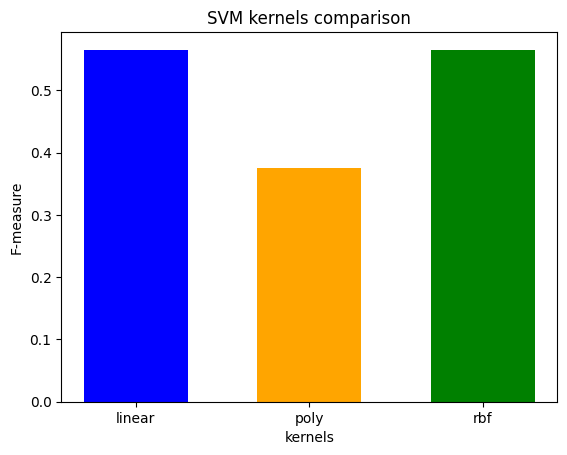

In [28]:
from sklearn.svm import SVC



# undersampling the train set
undersampling = 10000
train_xus = train_x[:undersampling]
train_yus = train_y[:undersampling]
test_xus = test_x[:undersampling]
test_yus = test_y[:undersampling]


kernels = ["linear", "poly", "rbf"]
svm_fmeasures = {}
svm_best_result = 0

for kernel in kernels:
    # create a SVM classifier instance and compute the prediction
    svm_classifier = SVC(kernel=kernel, degree=8, class_weight='balanced')
    svm_classifier.fit(train_xus, train_yus)
    y_pred = svm_classifier.predict(test_xus)

    # calculate F-measures and save best model
    acc, f1, prec, rec = get_scores(test_yus, y_pred)
    svm_fmeasures[kernel] = f1
    print(f"{kernel}:{f1} - {acc}")
    if svm_fmeasures[kernel] > svm_best_result:
        svm_best_result = svm_fmeasures[kernel]
        svm_best_model = svm_classifier
    


plt.bar(svm_fmeasures.keys(), svm_fmeasures.values(), color=['blue', 'orange', 'green', 'red'], width=.6)
plt.title('SVM kernels comparison')
plt.xlabel('kernels')
plt.ylabel('F-measure')
plt.show()


Random Forest

acc: 0.876 - f1: 0.5571428571428572
acc: 0.879 - f1: 0.5663082437275986
acc: 0.89 - f1: 0.5769230769230769
acc: 0.888 - f1: 0.5692307692307692
acc: 0.902 - f1: 0.5701754385964912
acc: 0.905 - f1: 0.5739910313901345
acc: 0.917 - f1: 0.5310734463276836
acc: 0.917 - f1: 0.5146198830409356
acc: 0.922 - f1: 0.5
acc: 0.919 - f1: 0.4774193548387097
acc: 0.918 - f1: 0.44594594594594594
acc: 0.923 - f1: 0.45390070921985815
acc: 0.921 - f1: 0.45517241379310347
acc: 0.921 - f1: 0.44755244755244755
acc: 0.878 - f1: 0.5611510791366906
acc: 0.885 - f1: 0.5756457564575646
acc: 0.89 - f1: 0.5769230769230769
acc: 0.89 - f1: 0.5703125
acc: 0.905 - f1: 0.5701357466063348
acc: 0.905 - f1: 0.5851528384279476
acc: 0.919 - f1: 0.5207100591715976
acc: 0.911 - f1: 0.49142857142857144
acc: 0.919 - f1: 0.4968944099378882
acc: 0.924 - f1: 0.49333333333333335
acc: 0.918 - f1: 0.4675324675324675
acc: 0.92 - f1: 0.4666666666666667
acc: 0.917 - f1: 0.4429530201342282
acc: 0.917 - f1: 0.4195804195804196
acc: 0.88 - f1

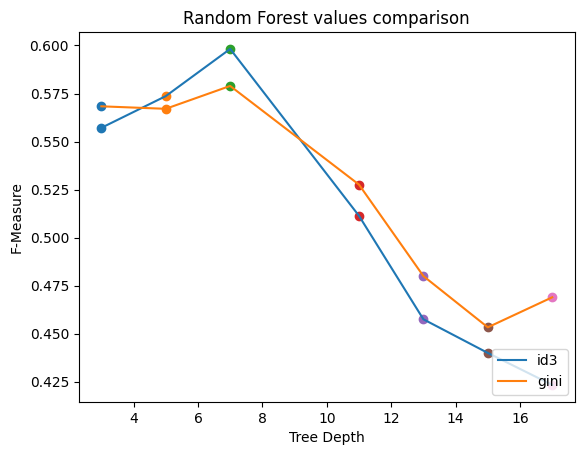

In [29]:
from sklearn.ensemble import RandomForestClassifier



# undersampling the train set
undersampling = 1000
train_xus = train_x[:undersampling]
train_yus = train_y[:undersampling]
test_xus = test_x[:undersampling]
test_yus = test_y[:undersampling]

# set Random Forest parameters
heuristics = ["entropy", "gini"]
max_depth = [3, 5, 7, 11, 13, 15, 17]
rf_fmeasures = {}
rf_best_result = 0
for j in range(5):
    for d in max_depth:
        rf_fmeasures[d] = np.zeros(len(heuristics))
        for (i, heuristic) in enumerate(heuristics):
            # create a Random Forest classifier instance and compute the prediction
            rf_classifier = RandomForestClassifier(n_estimators=100, criterion=heuristic, max_depth=d, class_weight='balanced')
            rf_classifier.fit(train_xus, train_yus)
            y_pred = rf_classifier.predict(test_xus)

            # calculate F-measures and save best model
            acc, f1, prec, rec = get_scores(test_yus, y_pred)
            print(f"acc: {acc} - f1: {f1}")
            rf_fmeasures[d][i] = f1
            if rf_fmeasures[d][i] > rf_best_result:
                rf_best_result = rf_fmeasures[d][i]
                rf_best_model = rf_classifier   
     

# plot the results
l1, l2 = [], []
for k in rf_fmeasures.keys():
    fmeasures = rf_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(rf_fmeasures[k][0])
    l2.append(rf_fmeasures[k][1])

# create line for each  models
plt.errorbar(max_depth, l1, label ='id3')
plt.errorbar(max_depth, l2, label ='gini')
plt.legend(loc ='lower right')
plt.title('Random Forest values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.show()